# Time series forecasting with ARIMA

In this notebook, we demonstrate how to:
- prepare time series data for training an ARIMA time series forecasting model
- implement a simple ARIMA model to forecast the next HORIZON steps ahead (time *t+1* through *t+HORIZON*) in the time series
- evaluate the model 


The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [2]:
pip install statsmodels

You should consider upgrading via the 'c:\Users\piete\OneDrive\Documents\Machine learning for beginners\ML-For-Beginners\sklearn-env\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [4]:
energy = load_data("./data")[["load"]]
energy.head(10)

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"
2012-01-01 05:00:00,"2,453.00"
2012-01-01 06:00:00,"2,560.00"
2012-01-01 07:00:00,"2,719.00"
2012-01-01 08:00:00,"2,916.00"
2012-01-01 09:00:00,"3,105.00"


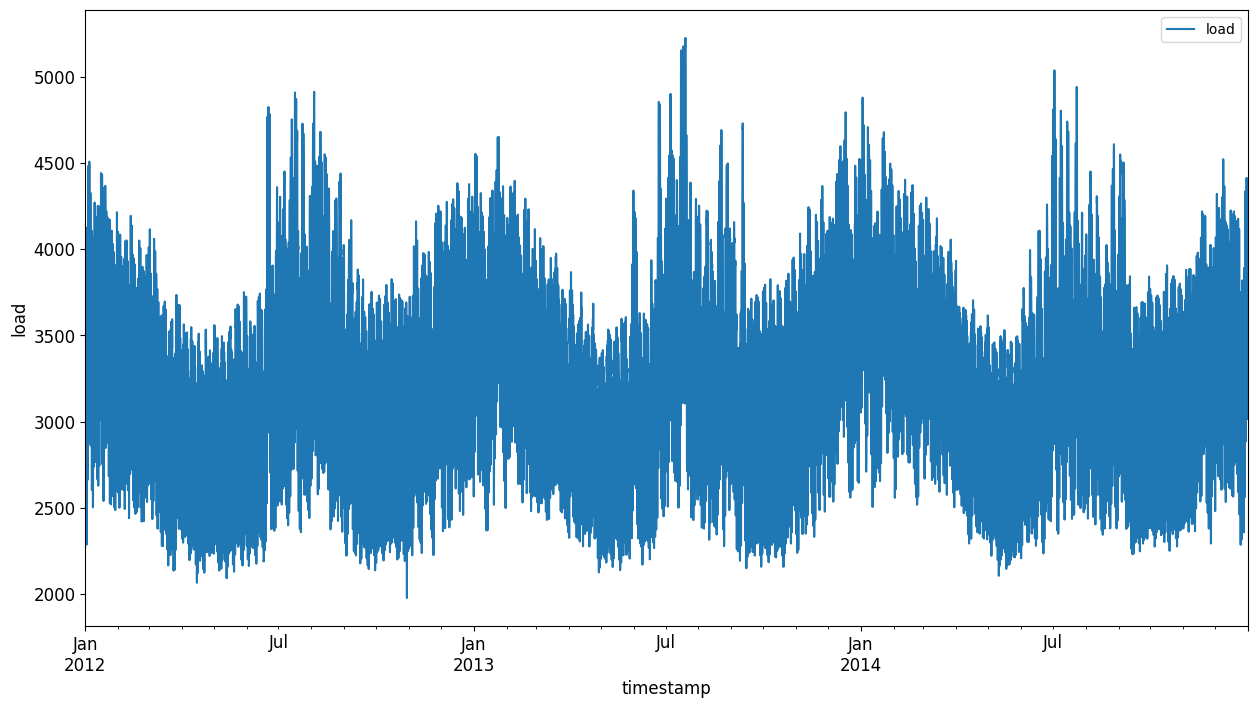

In [5]:
energy.plot(y="load", subplots=True, figsize=(15,8), fontsize=12)
plt.xlabel("timestamp", fontsize = 12)
plt.ylabel("load", fontsize= 12)
plt.show()

In [6]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

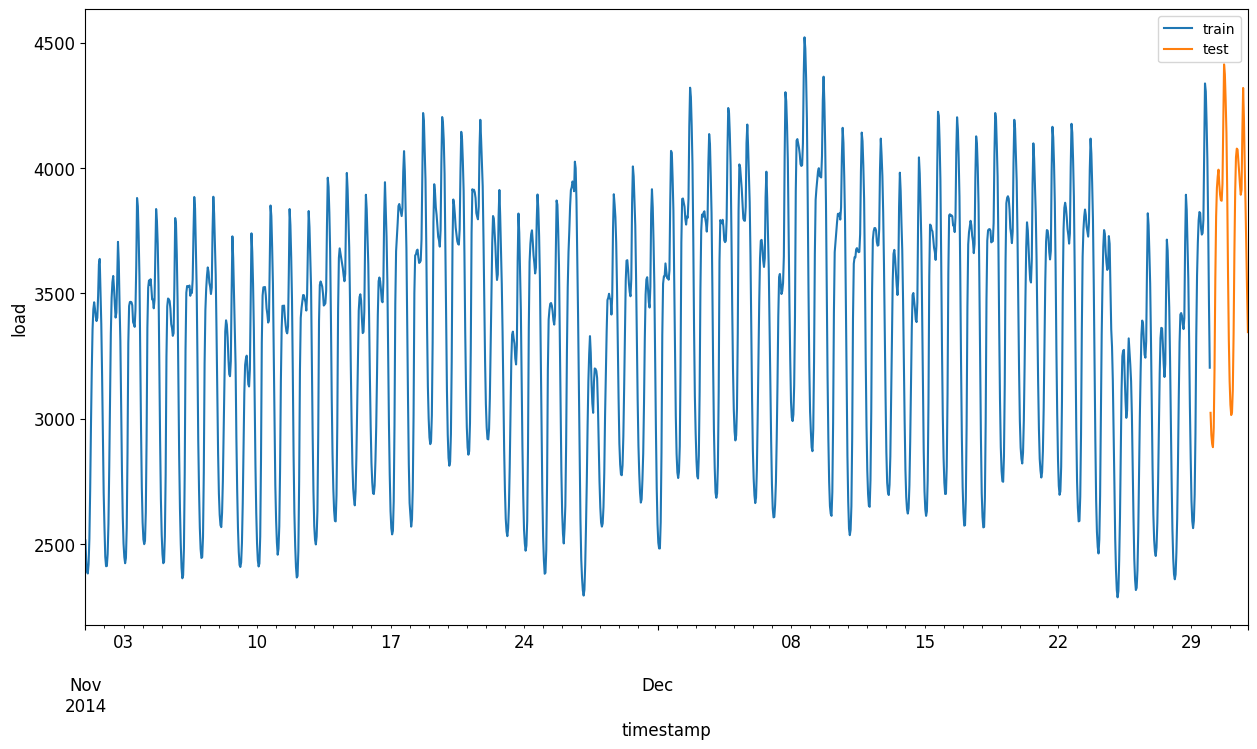

In [7]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
        .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
        .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [8]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [9]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06
2014-11-01 05:00:00,0.10
2014-11-01 06:00:00,0.19
2014-11-01 07:00:00,0.31
2014-11-01 08:00:00,0.40
2014-11-01 09:00:00,0.48


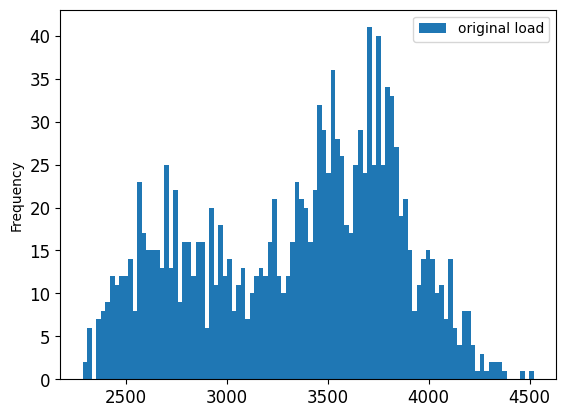

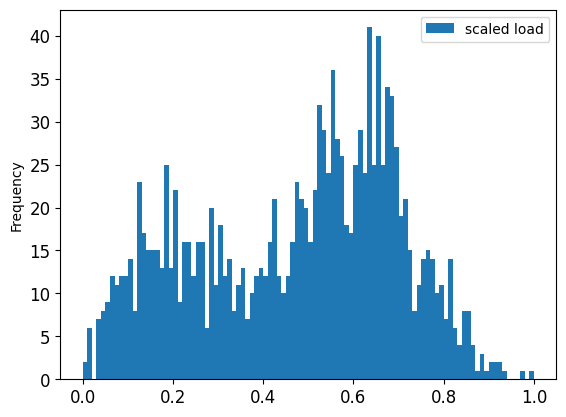

In [10]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [11]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


In [12]:
HORIZON = 3
print('forecasting horizon:', HORIZON, 'hours')

forecasting horizon: 3 hours


In [13]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.240
Date:                            Sat, 27 Sep 2025   AIC                          -6942.480
Time:                                    14:42:30   BIC                          -6911.053
Sample:                                11-01-2014   HQIC                         -6930.728
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8400      0.016     52.182      0.000       0.808       0.872
ar.L2         -0.5219      0.034   

In [14]:
test_shifted = test.copy()

for t in range(1, HORIZON+1):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2,load+3
2014-12-30 00:00:00,0.33,0.29,0.27,0.27
2014-12-30 01:00:00,0.29,0.27,0.27,0.30
2014-12-30 02:00:00,0.27,0.27,0.30,0.41
2014-12-30 03:00:00,0.27,0.30,0.41,0.57
2014-12-30 04:00:00,0.30,0.41,0.57,0.68


In [ ]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

In [ ]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

NameError: name 'pd' is not defined